# **NAME**: ______________

# Lab 4 Local Descriptor and Correspondance

In this lab, we will find corresponding points and regions between images using Harris corner detector. **Complete the implementation below and submit this notebook with your own result by Oct 7 23:59**.

## 1. Harris Corner Detector

The Harris corner detection algorithm is one of the simplest corner indicators available. The general idea is to locate interest points where the surrounding neighborhood shows edges in more than one direction, these are then image corners.

Following the lecture on 9/23, let's first implement the matrix $M$,
$$
M = \sum_{x,y} w(x,y) \begin{bmatrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{bmatrix}
$$
We use Gaussian filter for the window function $w(x, y)$.

Then we calculate the corner resopnse function,
$$
R = \det(M) - \alpha \text{trace}(M)^2
$$

Complete the functions below, which returns $I_x$, $I_y$, $I_{xy}$ and the corner response function.

In [ ]:
from scipy.ndimage import gaussian_filter
import numpy as np

def compute_harris_response(im, sigma=3, alpha=0.05, return_derivatives=True):
    """ Compute the Harris corner detector response function
    for each pixel in a graylevel image.
    """
    # Derivatives
    ix = ...
    iy = ...
    ixy = ...

    # Compute components of the Harris matrix
    Wxx = gaussian_filter(..., sigma)
    Wxy = gaussian_filter(..., sigma)
    Wyy = gaussian_filter(..., sigma)

    # Determinant and trace
    Wdet = ...
    Wtr = ...
    response = ...

    if return_derivatives:
        return ix, iy, ixy, response
    return response

This gives an image with each pixel containing the value of the Harris response function. Now it is just a matter of picking out the information needed from this image.

Take all points with values above a threshold and select every point with the largest value among its neighbors (non-maximum surpression).

To do this, take all candidate pixels, sort them in descending order of corneresponse values, and filter out points that are smaller than adjecent points.

In [ ]:
def get_harris_points(harrisim, window=10, threshold=0.1):
    """ Return corners from a Harris response image.
    window is the window size separating corners and
    image boundary during non-maximum suppression.
    """
    # Find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # Get coordinates of candidates
    coords = np.array(harrisim_t.nonzero()).T

    # ...and their values
    candidate_values = [harrisim[c[0],c[1]] for c in coords]

    # Sort candidates
    index = np.argsort(candidate_values)[::-1] # Sort in descending order

    # Select the best points using non-maximum suppression
    filtered_coords = []
    # Create a copy of the harris response image for suppression
    harrisim_suppressed = harrisim.copy()

    for i in index:
        r, c = coords[i]
        # Ensure point is within the image boundary considering min_dist
        if r > window and r < harrisim.shape[0] - window and c > window and c < harrisim.shape[1] - window:
            # Check if the current point has the maximum response in its neighborhood
            if harrisim_suppressed[r, c] == harrisim[r, c]:
                filtered_coords.append((r, c))
                # Suppress the neighborhood using min_dist as the size of the suppression window
                harrisim_suppressed[max(0, r - window):min(harrisim.shape[0], r + window + 1),
                                    max(0, c - window):min(harrisim.shape[1], c + window + 1)] = 0

    return filtered_coords

Now we have all we need to detect corner points in images. To show the corner
points in the image we can add a plotting function using Matplotlib as follows.

In [ ]:
import matplotlib.pyplot as plt

def normalize(im):
    im = (im - im.min()) / (im.max() - im.min())
    im = (im * 255).astype(np.uint8)
    return im

def plot_harris_points(image, filtered_coords):
    """ Plots corners found in image.
    """
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords], 'o')
    plt.axis('off')
    plt.show()

Detect the corners of `checkboard.png` and `cameraman.png`. Show their $I_x$, $I_y$, and $I_{xy}$

### Checkboard

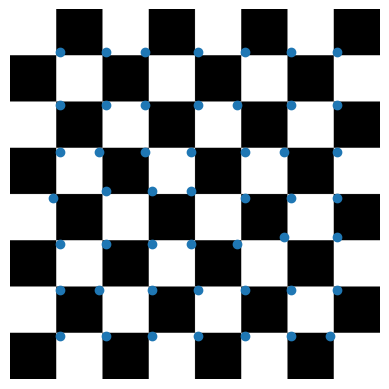

In [ ]:
from PIL import Image

im = np.array(Image.open('checkboard.png').convert('L'))
...
plot_harris_points(im, ...)

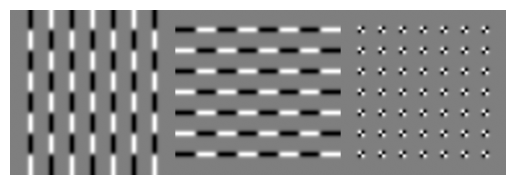

In [ ]:
derivatives = np.concatenate([normalize(ix), normalize(iy), normalize(ixy)], axis=1)
plt.imshow(derivatives)
plt.axis('off')
plt.show()

### Cameraman

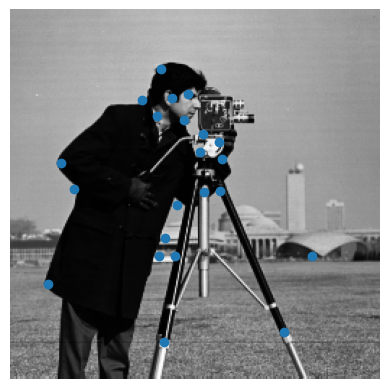

In [ ]:
im = np.array(Image.open('cameraman.png').convert('L'))
...
plot_harris_points(im, ...)

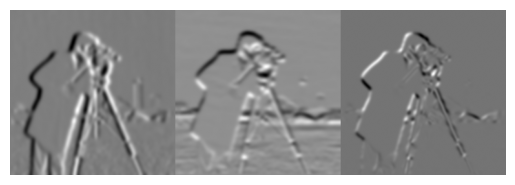

In [ ]:
derivatives = np.concatenate([normalize(ix), normalize(iy), normalize(ixy)], axis=1)
plt.imshow(derivatives)
plt.axis('off')
plt.show()

### Analysis

Incrementally apply stronger blur (or ROF de-noising) to one image and extract Harris corners. What happens?

Show the results and provide your analysis.

_Answer_

## 2. Finding Corresponding Points between Images

Next, let's find corresponding points between images. We will first detect points (corners) in the two images and then match similar points between the images by estimating their similarity.

After detecting points using Harris corner detection in the previous section, we crop patches from the images at the corners.

In [ ]:
def get_descriptors(image, filtered_coords, wid=5):
    """ For each point return pixel values around the point
        using a neighbourhood of width 2*wid+1. (Assume points are
        extracted with min_distance > wid). """

    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
            coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)

    return desc

Then we estimate the similarity between patches of the two images using _Normalized Cross Correlation_ (NCC).

_Normalized cross correlation_ is a variant of cross correlation defined as
$$
\text{NCC}(I_1, I_2) = \frac{1}{n-1} \sum_{\mathbf{x}} \frac{(I_1(\mathbf{x}) - \mu_1)}{\sigma_1} \cdot \frac{(I_2(\mathbf{x}) - \mu_2)}{\sigma_2},
$$

where $n$ is the number of pixels in a patch, $\mu_1$ and $\mu_2$ are the mean intensities, and
$\sigma_1$ and $\sigma_2$ are the standard deviations in each patch respectively. By subtracting the
mean and scaling with the standard deviation, the method becomes robust to changes in image brightness.

In [ ]:
def match(desc1, desc2, threshold=0.5):
    """ For each corner point descriptor in the first image,
    select its match to second image using
    normalized cross correlation.
    """

    n = len(desc1[0])

    # pair-wise distances
    d = -np.ones((len(desc1), len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = ...
            d2 = ...
            ncc_value = sum(d1 * d2) / (n-1)
            if ncc_value > threshold:
                d[i,j] = ncc_value

    ndx = np.argsort(-d)
    matchscores = ndx[:,0]

    return matchscores

To further stabilize the matches, we can match from the second image to the
first and filter out the matches that are not the best both ways. The following function does just that.

In [ ]:
def match_twosided(desc1, desc2, threshold=0.5):
    """ Two-sided symmetric version of match(). """

    matches_12 = match(desc1, desc2, threshold)
    matches_21 = match(desc2, desc1, threshold)
    ndx_12 = np.where(matches_12 >= 0)[0]

    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1

    return matches_12

The matches can be visualized by showing the images side-by-side and connecting matched points with lines using the following code.

In [ ]:
def appendimages(im1, im2):
    """ Return a new image that appends the two images side-by-side."""

    # select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]
    rows2 = im2.shape[0]

    if rows1 < rows2:
        im1 = np.concatenate((im1, np.zeros((rows2-rows1, im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = np.concatenate((im2, np.zeros((rows1-rows2, im2.shape[1]))), axis=0)
    # if none of these cases they are equal, no filling needed.

    return np.concatenate((im1,im2), axis=1)

def plot_matches(im1, im2, locs1, locs2, matchscores, show_below=True):
    """ Show a figure with lines joining the accepted matches
    input: im1,im2 (images as arrays), locs1,locs2 (feature locations),
    matchscores (as output from ’match()’),
    show_below (if images should be shown below matches). """

    im3 = appendimages(im1, im2)
    if show_below:
        im3 = np.vstack((im3, im3))

    plt.imshow(im3)

    cols1 = im1.shape[1]
    for i, m in enumerate(matchscores):
        if m > 0:
            plt.plot([locs1[i][1], locs2[m][1]+cols1], [locs1[i][0], locs2[m][0]], 'c')
    plt.axis('off')

Plot the matching results between `ucm1.jpg` and `ucm2.jpg`.

starting matching


<Figure size 640x480 with 0 Axes>

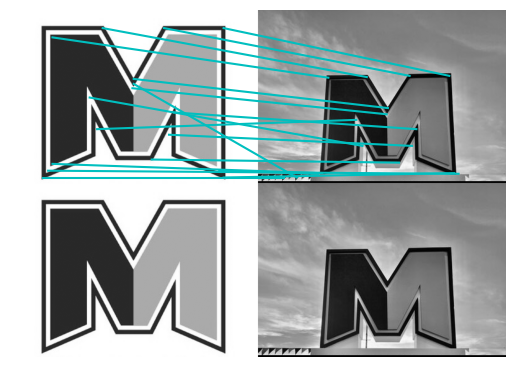

In [ ]:
im1 = np.array(Image.open('ucm1.jpg').convert('L'))
im2 = np.array(Image.open('ucm2.jpg').convert('L'))

d1 = get_descriptors(im1, ...)

d2 = get_descriptors(im2, ...)

print('starting matching')
matches = match_twosided(d1, d2)

plt.figure()
plt.gray()
plt.show()
plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)

## Analysis

Which parts match, and which parts fail? Describe what you observe.

_Answer_